In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)

# Analysis of Bias symptoms

The goal of the analysis is to identify symptoms that allow to predict the value of some bias metrics without training a classification model. 

The metrics are the following:

- **Statistical Parity:**

$$
SP = P(\hat{Y} = 1 | A = 0) - P(\hat{Y} = 1 | A = 1)
$$

- **Equal Opportunity:**

$$
EO = P(\hat{Y} = 1 | A = 0, Y = 1) - P(\hat{Y} = 1 | A = 1, Y = 1)
$$

- **Average Odds:**

$$
AO = \left[ P(\hat{Y} = 1 | A = 0, Y = 1) - P(\hat{Y} = 1 | A = 1, Y = 1) \right] \\ + \left[ P(\hat{Y} = 1 | A = 0, Y = 0) - P(\hat{Y} = 1 | A = 1, Y = 0) \right]
$$

The considered symptoms are the following:

- **Correlation**: Kendall correlation factor between the sensitive attribute and the label
- **Mutual Information**: Mutual information between the sensitive attribute and the label
- **Unprivileged Positive Probability**: Probability of the label being 1 given the sensitive attribute is 0
- **Privileged Positive Probability**: Probability of the label being 1 given the sensitive attribute is 1
- **Unprivileged Negative Probability**: Probability of the label being 0 given the sensitive attribute is 0
- **Privileged Negative Probability**: Probability of the label being 0 given the sensitive attribute is 1
- **Positive Probability Difference**: Difference between the unprivileged positive probability and the privileged positive probability
- **Negative Probability Difference**: Difference between the unprivileged negative probability and the privileged negative probability
- **Group Unbalance**: Ratio between the number of samples with sensitive attribute 0 and the number of samples with sensitive attribute 1


In [47]:
data = pd.read_csv("bias_symptoms.csv", index_col=[0, 1])
# data.drop(columns=["correlation_pred"], inplace=True)
# data.dropna(inplace=True)
# data.rename(columns={"unpriv_prob": "unpriv_prob_pos", "priv_prob": "priv_prob_pos"}, inplace=True)
# data['unpriv_prob_neg'] = 1 - data['unpriv_prob_pos']
# data['priv_prob_neg'] = 1 - data['priv_prob_pos']
# data['pos_prob'] = data['unpriv_prob_pos'] - data['priv_prob_pos']
# data['neg_prob'] = data['unpriv_prob_neg'] - data['priv_prob_neg']
# data.set_index(['variable', 'data'], inplace=True)
# data.to_csv("bias_symptoms.csv")

## Percentage of variables detected as biased by the different metrics

In [48]:
threshold = 0.2

In [49]:
stat_par = data[data.statistical_parity.abs() > threshold]
stat_par = stat_par.shape[0] / data.shape[0]
eq_odds = data[data.equal_opportunity.abs() > threshold]
eq_odds = eq_odds.shape[0] / data.shape[0]
av_odds = data[data.average_odds.abs() > threshold]
av_odds = av_odds.shape[0] / data.shape[0]

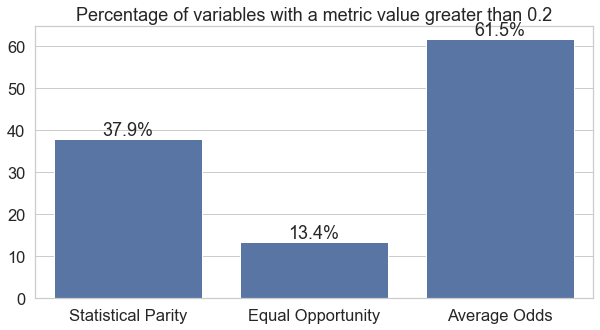

In [50]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=["Statistical Parity", "Equal Opportunity", "Average Odds"], 
            y=[stat_par*100, eq_odds*100, av_odds*100])
plt.bar_label(ax.containers[0], fmt='%.1f%%', label_type='edge')
plt.title("Percentage of variables with a metric value greater than 0.2")
plt.show()

## Distribution of bias metrics values

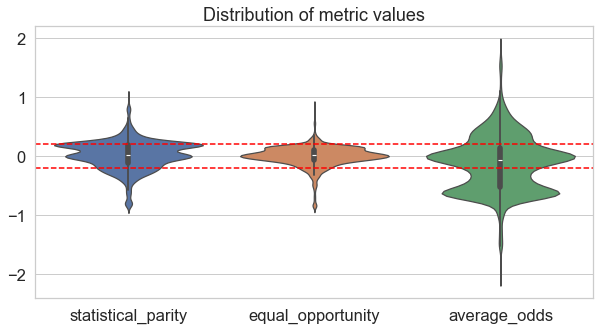

In [51]:
plt.figure(figsize=(10, 5))
ax = sns.violinplot(
    data=data[["statistical_parity", "equal_opportunity", "average_odds"]],
)
plt.axhline(y=0.2, color="red", linestyle="--")
plt.axhline(y=-0.2, color="red", linestyle="--")
plt.title("Distribution of metric values")
plt.show()

## Correlation Analysis

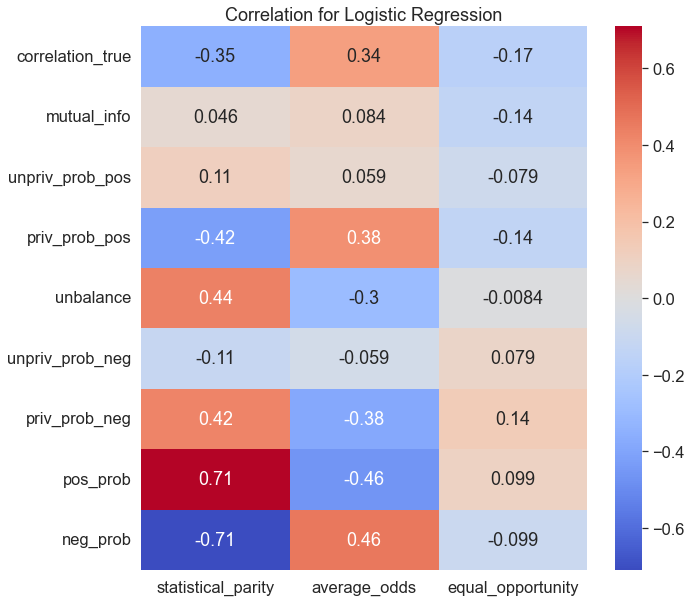

In [52]:
correlation = data.corr("pearson")

plt.figure(figsize=(10, 10))

sns.heatmap(
  correlation[['statistical_parity', 'average_odds', 'equal_opportunity']].drop(['statistical_parity', 'average_odds', 'equal_opportunity'], axis=0), 
  annot=True, 
  cmap="coolwarm")
plt.title("Correlation for Logistic Regression")
plt.show()

## Analysis of the symptoms distribution

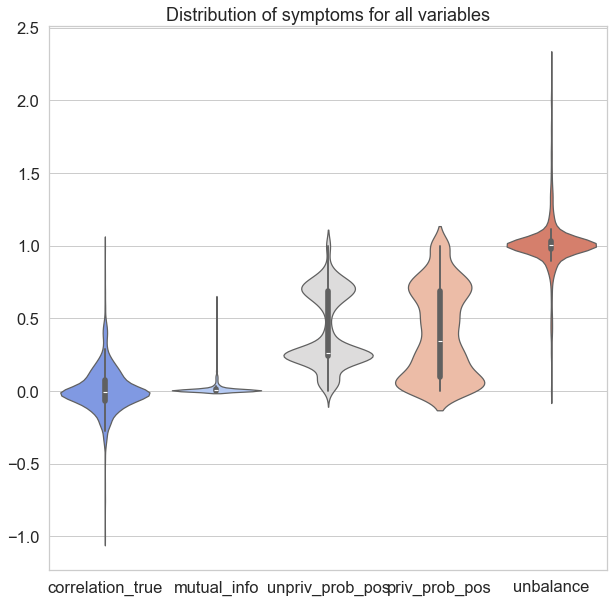

In [53]:
plt.figure(figsize=(10, 10))
sns.violinplot(
    data=data[["correlation_true", "mutual_info", "unpriv_prob_pos", "priv_prob_pos", "unbalance"]],
    palette="coolwarm"
)
plt.title("Distribution of symptoms for all variables")
plt.show()

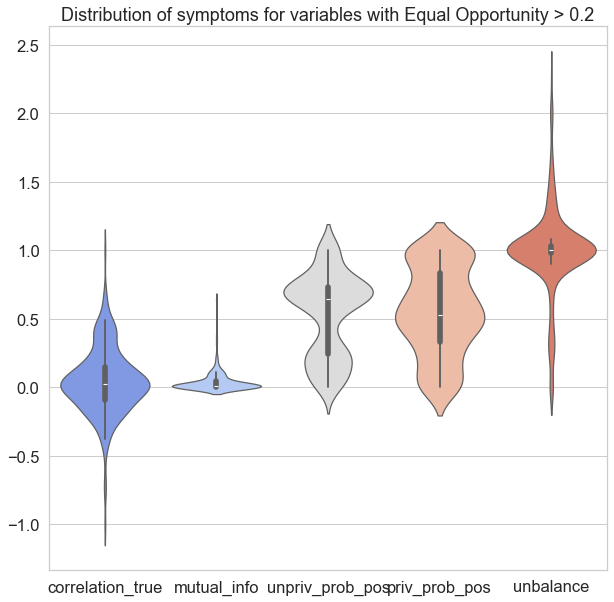

In [54]:
data_new = data[data["equal_opportunity"].abs() > 0.2]
plt.figure(figsize=(10, 10))
sns.violinplot(
    data=data_new[
        ["correlation_true", "mutual_info", "unpriv_prob_pos", "priv_prob_pos", "unbalance"]
    ],
    palette="coolwarm",
)
plt.title("Distribution of symptoms for variables with Equal Opportunity > 0.2")
plt.show()

## Predicting the metrics from the symptoms

In [55]:
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

In [56]:
def train_model(model, data, label):
    scores = []
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    for itrain, itest in kfold.split(data):
        train, test = data.iloc[itrain], data.iloc[itest]
        model.fit(
            train.drop(
                columns=["statistical_parity", "equal_opportunity", "average_odds"]
            ),
            train[label],
        )
        scores.append(
            model.score(
                test.drop(
                    columns=["statistical_parity", "equal_opportunity", "average_odds"]
                ),
                test[label],
            )
        )
    return scores

### Statistical Parity with Linear Regression

In [57]:
model = LinearRegression()
sp_linreg_symp = train_model(model, data, "statistical_parity")

In [58]:
np.mean(sp_linreg_symp)

0.5315112578737891

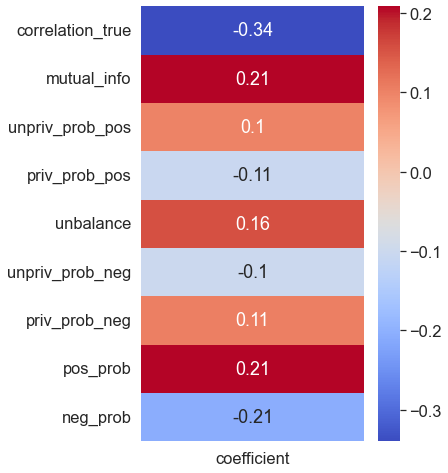

In [59]:
plt.figure(figsize=(5, 8))
sns.heatmap(pd.DataFrame(model.coef_, index=data.drop(columns=["statistical_parity", "equal_opportunity", "average_odds"]).columns, columns=['coefficient']), annot=True, cmap="coolwarm")
plt.show()

### Statistical Parity with XGBoost

In [60]:
model = XGBRegressor()
sp_xgb_symp = train_model(model, data, "statistical_parity")

In [61]:
np.mean(sp_xgb_symp)

0.42081206652413117

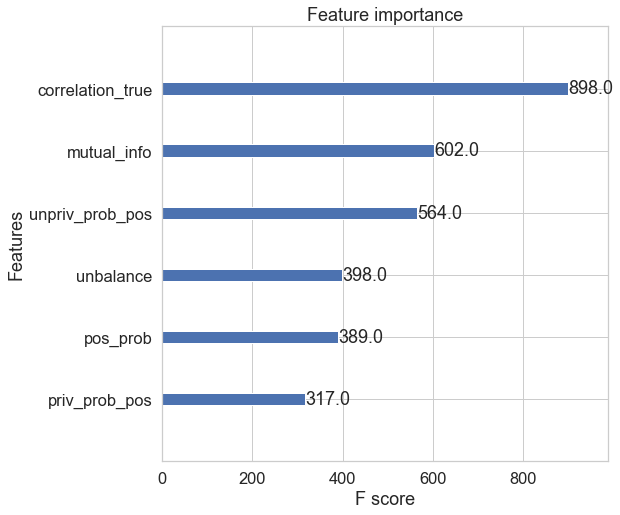

In [62]:
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, ax)
plt.show()

### Equal Opportunity with Linear Regression

In [63]:
model = LinearRegression()
ep_linreg_symp = train_model(model, data, "equal_opportunity")

In [64]:
np.mean(ep_linreg_symp)

0.029096102530746293

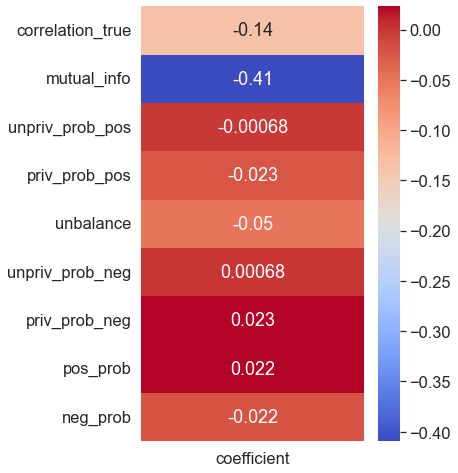

In [65]:
plt.figure(figsize=(5, 8))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=data.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Equal Opportunity with XGBoost

In [66]:
model = XGBRegressor()
eo_xgb_symp = train_model(model, data, "equal_opportunity")

In [67]:
np.mean(eo_xgb_symp)

-0.02824018634766976

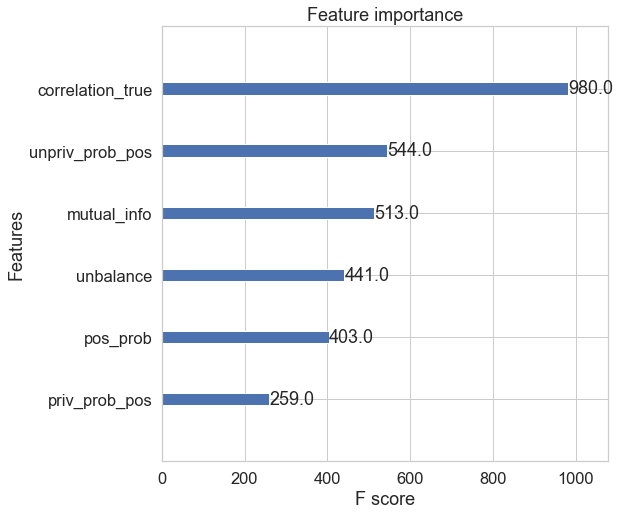

In [68]:
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, ax)
plt.show()

### Average Odds with Linear Regression

In [69]:
model = LinearRegression()
ao_linreg_symp = train_model(model, data, "average_odds")

In [70]:
np.mean(ao_linreg_symp)

0.27957772377794593

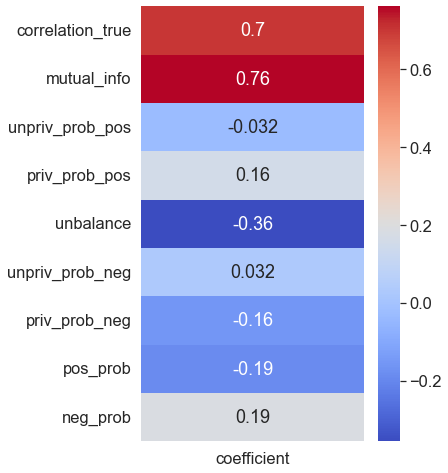

In [71]:
plt.figure(figsize=(5, 8))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=data.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Average Odds with XGBoost

In [72]:
model = XGBRegressor()
ao_xgb_symp = train_model(model, data, "average_odds")

In [73]:
np.mean(ao_xgb_symp)

0.4143744774030981

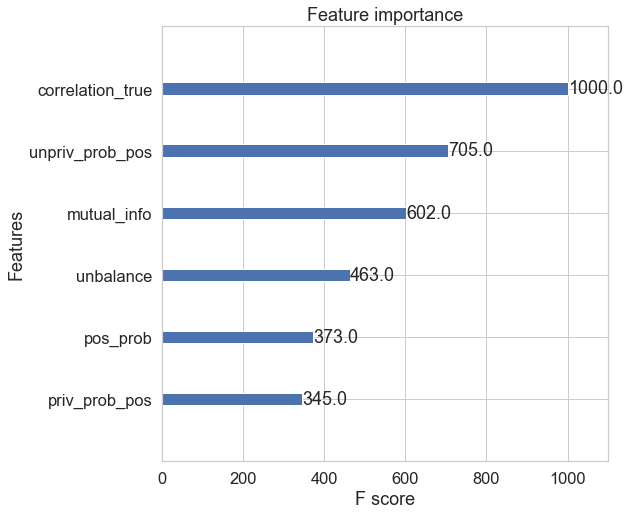

In [74]:
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, ax)
plt.show()

## Predicting the metrics from the metafeatures alone

In [75]:
meta_new = pd.read_csv("metafeatures.csv", index_col=[0,1])
# meta.rename(columns={"dataset_name": "data"}, inplace=True)
# meta['data'] = meta.data.apply(lambda x: x.split(".")[0])
# meta['data'] = meta.data.apply(lambda x: x.split("_")[0])
# meta.set_index(["variable", "data"], inplace=True)
# meta.drop(meta.index.unique(level=1).difference(data.index.unique(level=1)), level=1, inplace=True)
# meta_new = meta.join(data[['statistical_parity', 'equal_opportunity', 'average_odds']])
# meta_new.dropna(inplace=True)
# meta_new.drop_duplicates(inplace=True)

In [76]:
# meta_new.to_csv("metafeatures.csv")

In [77]:
meta_new

instance_num  log_inst_num  class_num  feat_num  \
variable  data                                                     
 10th     adult          3094      8.037220          2       102   
          adult          3094      8.037220          2       102   
          adult          3094      8.037220          2       102   
          adult          3094      8.037220          2       102   
          adult          3094      8.037220          2       102   
...                       ...           ...        ...       ...   
wife_work cmc             147      4.990433          3        10   
          cmc             147      4.990433          3        10   
          cmc             147      4.990433          3        10   
          cmc             147      4.990433          3        10   
          cmc             147      4.990433          3        10   

                 log_feat_num  inst_missing_vals  perc_inst_missing_val  \
variable  data                                                            
 10th     adult      4.624973                  0                      0   
          adult      4.624973                  0                      0   
          adult      4.624973                  0                      0   
          adult      4.624973                  0                      0   
          adult      4.624973                  0                      0   
...                       ...                ...                    ...   
wife_work cmc        2.302585                  0                      0   
          cmc        2.302585                  0                      0   
          cmc        2.302585                  0                      0   
          cmc        2.302585                  0                      0   
          cmc        2.302585                  0                      0   

                 feat_missing_val  perc_feat_missing_val  missing_vals  ...  \
variable  data                                                          ...   
 10th     adult                 0                      0             0  ...   
          adult                 0                      0             0  ...   
          adult                 0                      0             0  ...   
          adult                 0                      0             0  ...   
          adult                 0                      0             0  ...   
...                           ...                    ...           ...  ...   
wife_work cmc                   0                      0             0  ...   
          cmc                   0                      0             0  ...   
          cmc                   0                      0             0  ...   
          cmc                   0                      0             0  ...   
          cmc                   0                      0             0  ...   

                 kurtosis_var  skew_min   skew_max  skew_mean   skew_std  \
variable  data                                                             
 10th     adult     26.974784 -3.085848  55.623736   11.07327  14.512954   
          adult     26.974784 -3.085848  55.623736   11.07327  14.512954   
          adult     26.974784 -3.085848  55.623736   11.07327  14.512954   
          adult     26.974784 -3.085848  55.623736   11.07327  14.512954   
          adult     26.974784 -3.085848  55.623736   11.07327  14.512954   
...                       ...       ...        ...        ...        ...   
wife_work cmc       -0.858026 -2.062346   2.786277   -0.18346   1.305768   
          cmc       -0.858026 -2.062346   2.786277   -0.18346   1.305768   
          cmc       -0.858026 -2.062346   2.786277   -0.18346   1.305768   
          cmc       -0.858026 -2.062346   2.786277   -0.18346   1.305768   
          cmc       -0.858026 -2.062346   2.786277   -0.18346   1.305768   

                 skew_var  class_entropy  statistical_parity  \
variable  data                                                 
 10th     a

### Predicting Statistical Parity with Linear Regression

In [78]:
model = LinearRegression()
sp_linreg_meta = train_model(model, meta_new, "statistical_parity")

In [79]:
np.mean(sp_linreg_meta)

0.07435968000028496

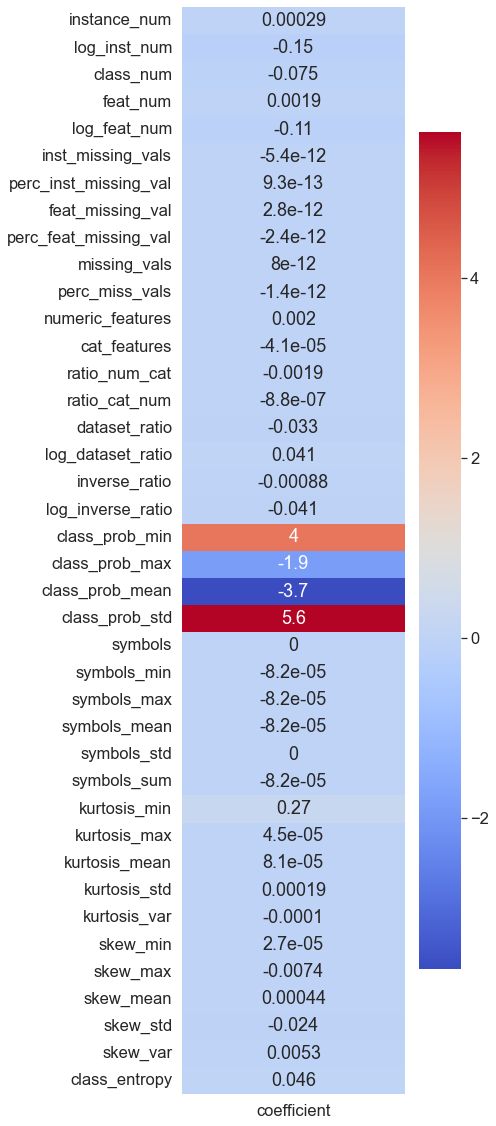

In [80]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=meta_new.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Statistical Parity with XGBoost

In [81]:
model = XGBRegressor()
sp_xgb_meta = train_model(model, meta_new, "statistical_parity")

In [82]:
np.mean(sp_xgb_meta)

0.4553313447416267

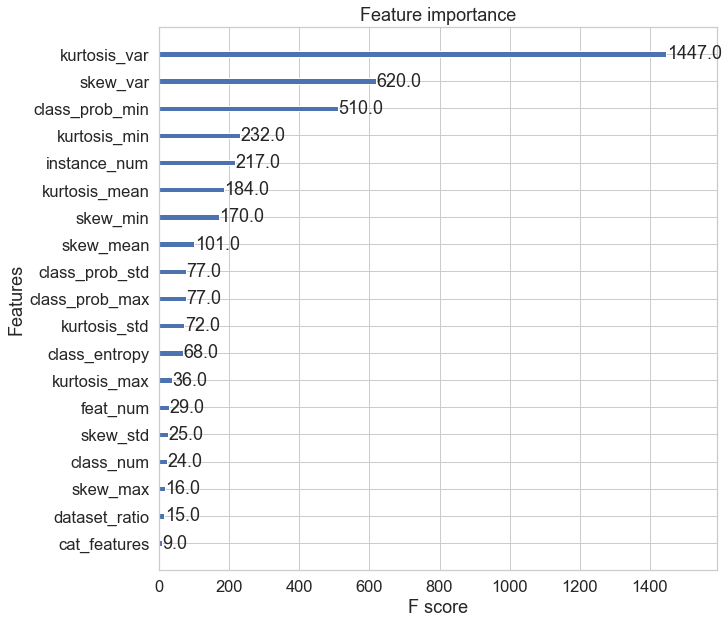

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

### Predicting Equal Opportunity with Linear Regression

In [84]:
model = LinearRegression()
ep_linreg_meta = train_model(model, meta_new, "equal_opportunity")

In [85]:
np.mean(ep_linreg_meta)

0.03713692753369633

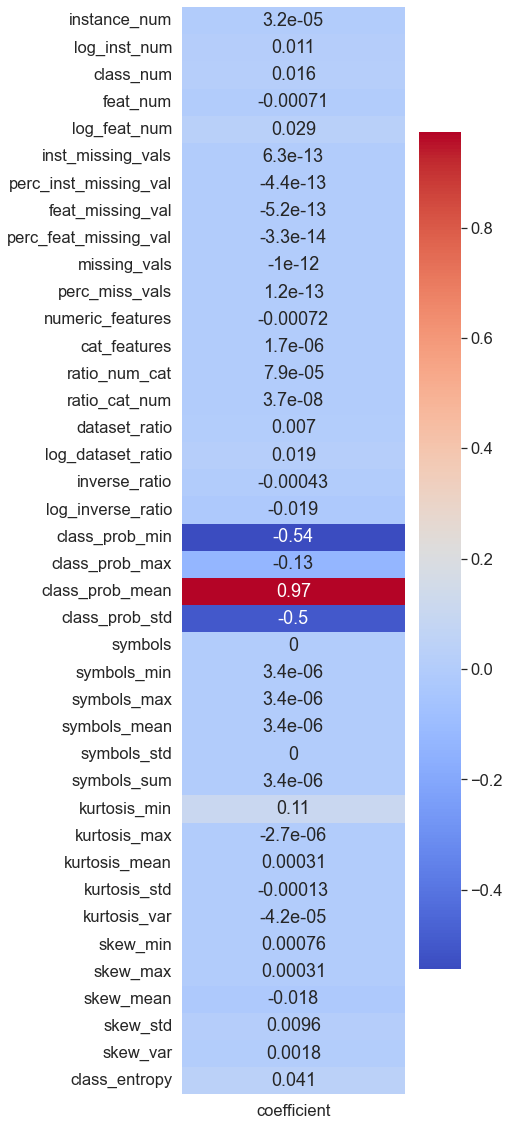

In [86]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=meta_new.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Equal Opportunity with XGBoost

In [87]:
model = XGBRegressor()
ep_xgb_meta = train_model(model, meta_new, "equal_opportunity")

In [88]:
np.mean(ep_xgb_meta)

0.17119154310695409

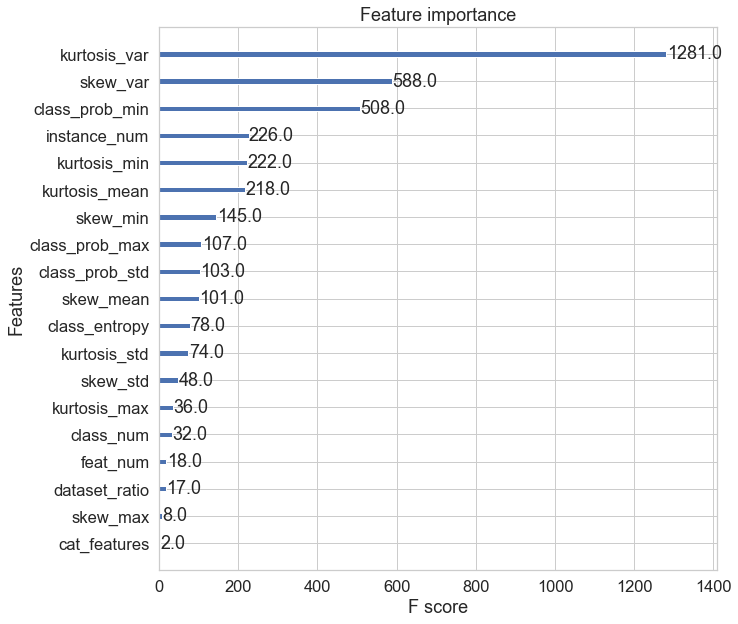

In [89]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

### Predicting Average Odds with Linear Regression

In [90]:
model = LinearRegression()
ao_linreg_meta = train_model(model, meta_new, "average_odds")

In [91]:
np.mean(ao_linreg_meta)

0.12472134005540284

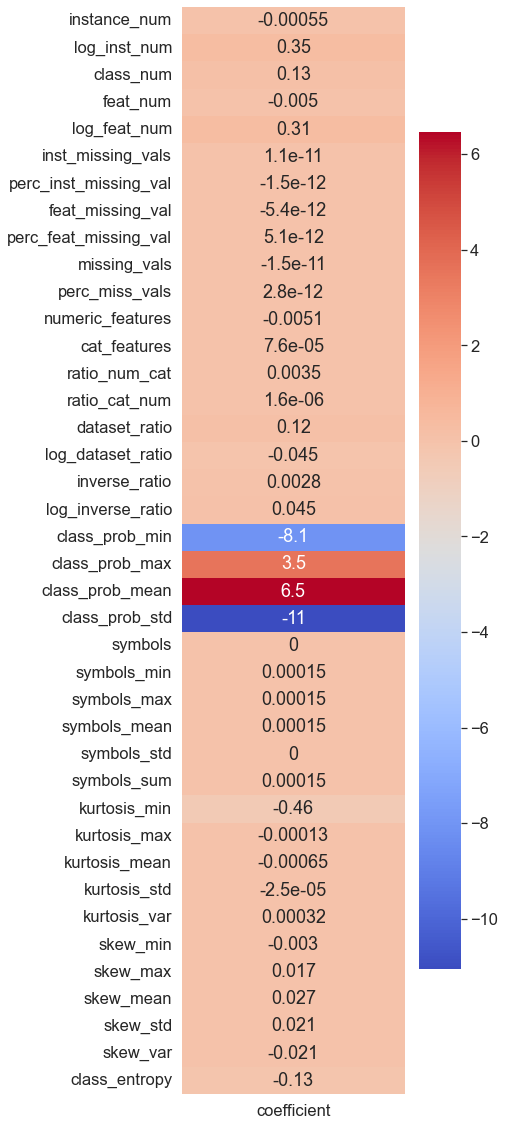

In [92]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=meta_new.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Average Odds with XGBoost

In [93]:
model = XGBRegressor()
ao_xgb_meta = train_model(model, meta_new, "average_odds")

In [94]:
np.mean(ao_xgb_meta)

0.503553174934327

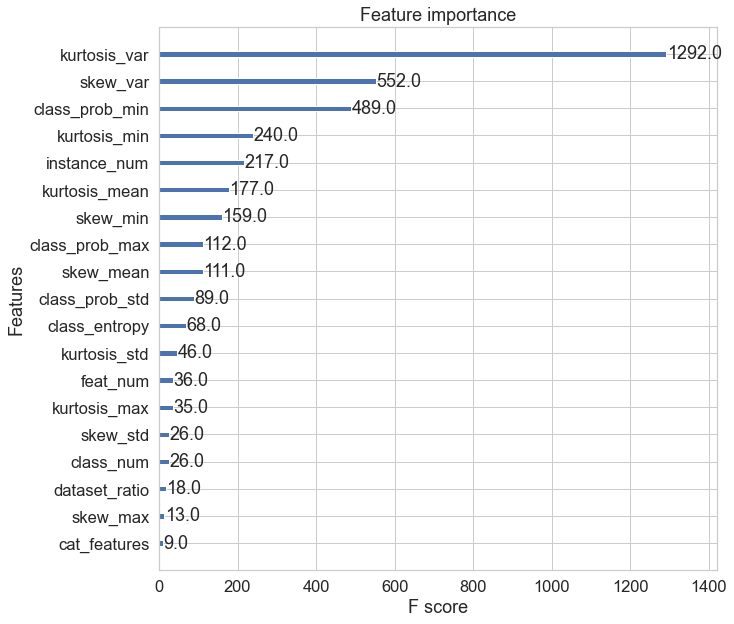

In [95]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

## Predicting the metrics from the symptoms and the metafeatures

In [98]:
joined = pd.read_csv("all_features.csv", index_col=[0,1])

### Predicting Statistical Parity with Linear Regression

In [99]:
model = LinearRegression()
sp_linreg_joined = train_model(model, joined, "statistical_parity")

In [100]:
np.mean(sp_linreg_joined)

0.5860627567672315

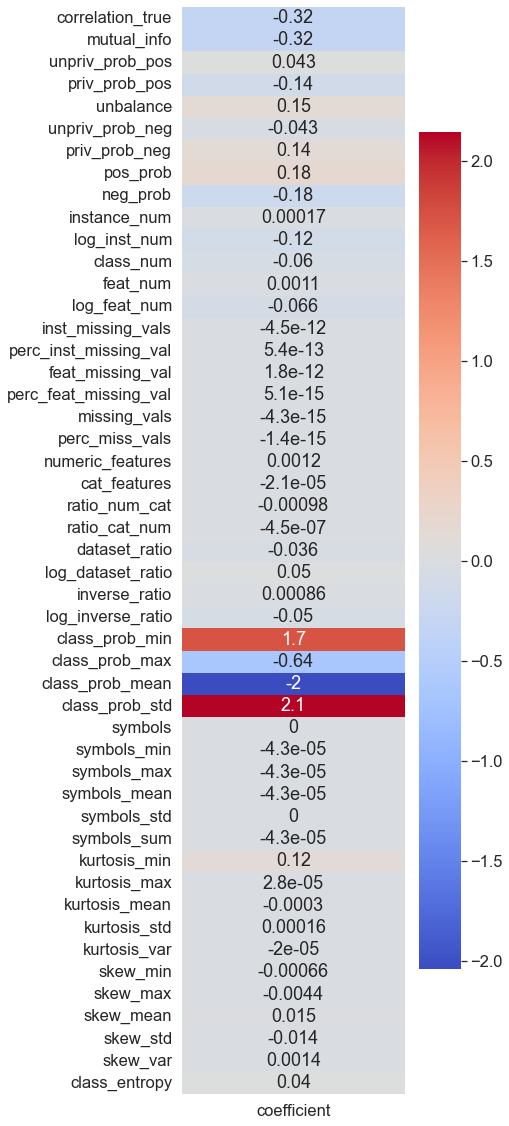

In [101]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=joined.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Statistical Parity with XGBoost

In [102]:
model = XGBRegressor()
sp_xgb_joined = train_model(model, joined, "statistical_parity")

In [103]:
np.mean(sp_xgb_joined)

0.8165475410571984

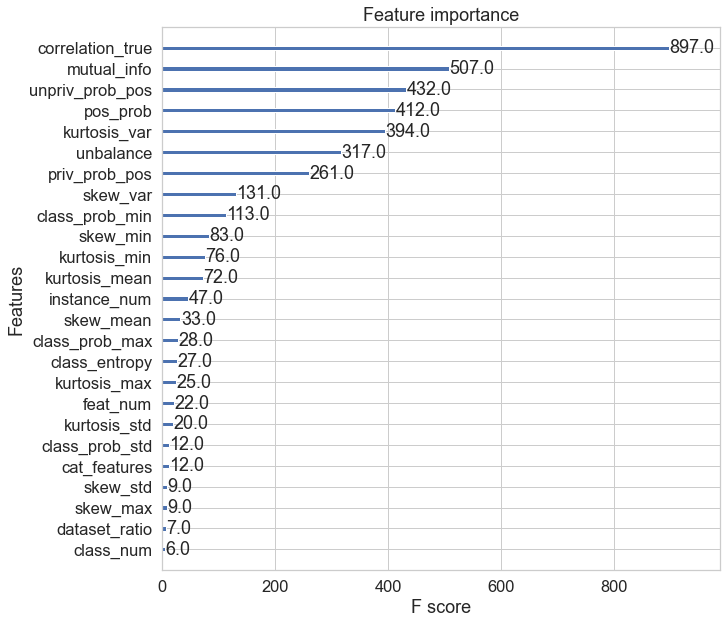

In [104]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

### Predicting Equal Opportunity with Linear Regression

In [105]:
model = LinearRegression()
ep_linreg_joined = train_model(model, joined, "equal_opportunity")

In [106]:
np.mean(ep_linreg_joined)

0.08940319203889939

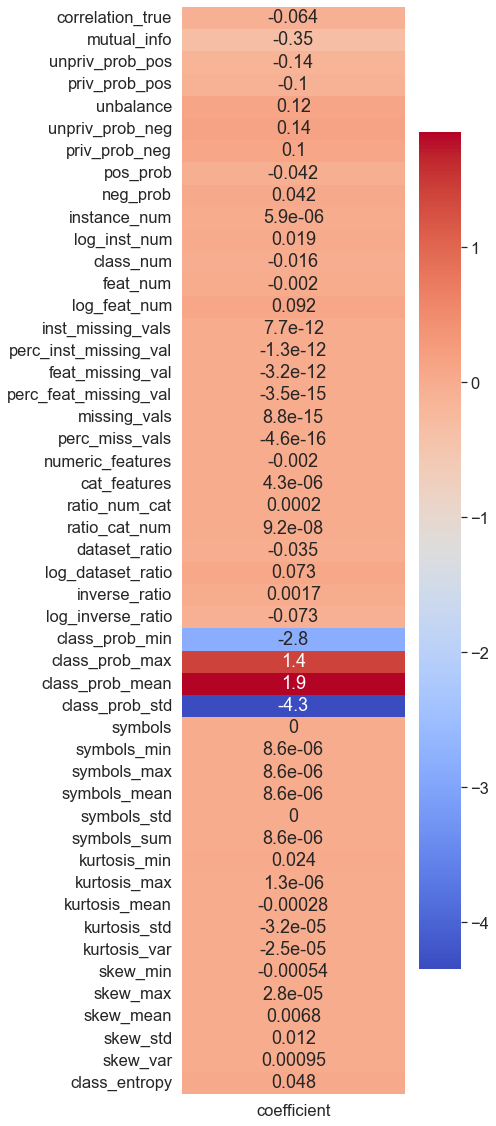

In [107]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=joined.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Equal Opportunity with XGBoost

In [108]:
model = XGBRegressor()
ep_xgb_joined = train_model(model, joined, "equal_opportunity")

In [109]:
np.mean(ep_xgb_joined)

0.6484021815285821

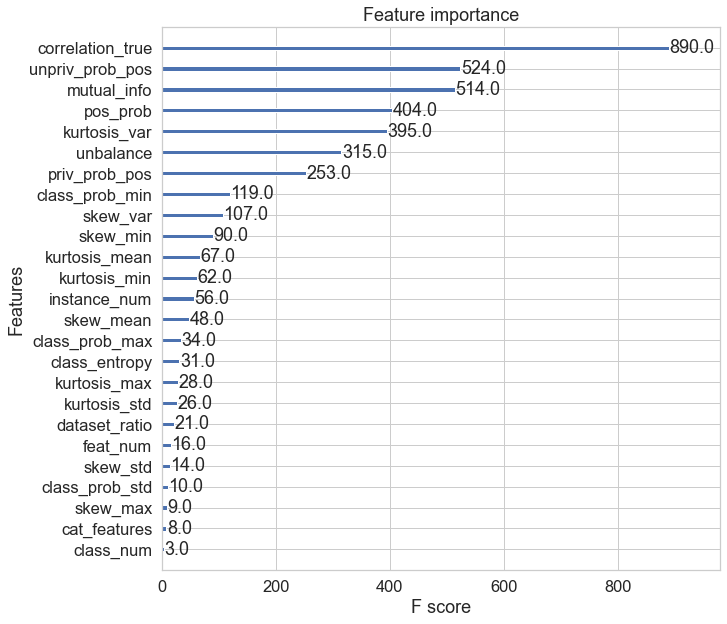

In [110]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

### Predicting Average Odds with Linear Regression

In [111]:
model = LinearRegression()
ao_linreg_joined = train_model(model, joined, "average_odds")

In [112]:
np.mean(ao_linreg_joined)

0.39173898283658415

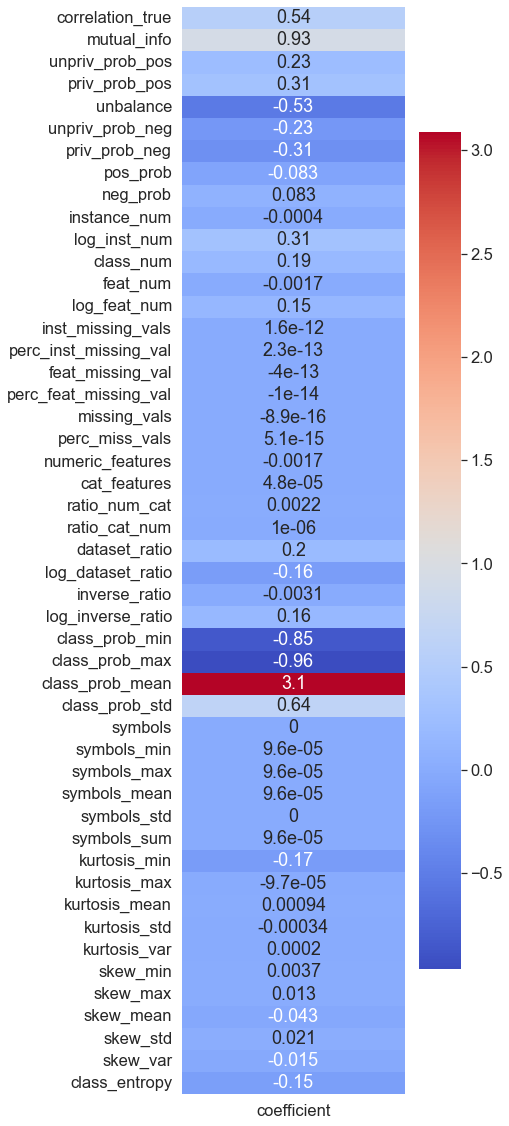

In [113]:
plt.figure(figsize=(5, 20))
sns.heatmap(
    pd.DataFrame(
        model.coef_,
        index=joined.drop(
            columns=["statistical_parity", "equal_opportunity", "average_odds"]
        ).columns,
        columns=["coefficient"],
    ),
    annot=True,
    cmap="coolwarm",
)

plt.show()

### Predicting Average Odds with XGBoost

In [114]:
model = XGBRegressor()
ao_xgb_joined = train_model(model, joined, "average_odds")

In [115]:
np.mean(ao_xgb_joined)

0.8843931947520034

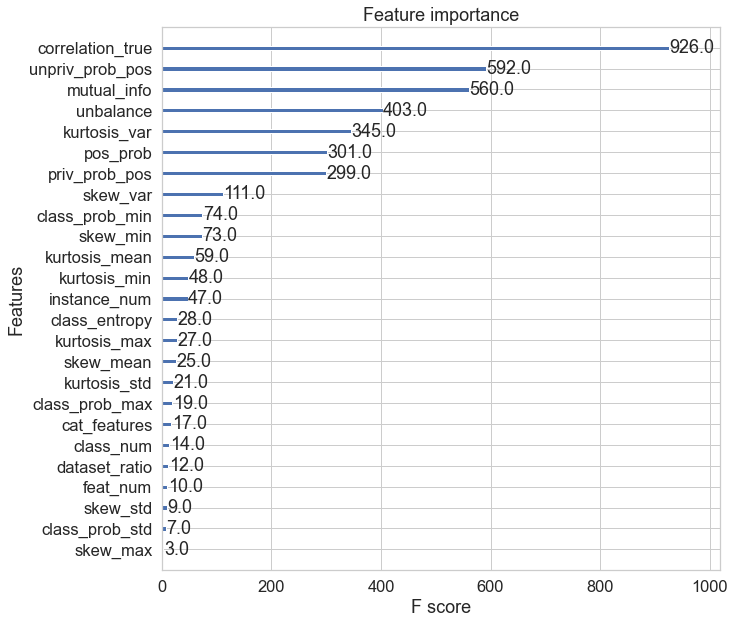

In [116]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax)
plt.show()

## Comparison of the results

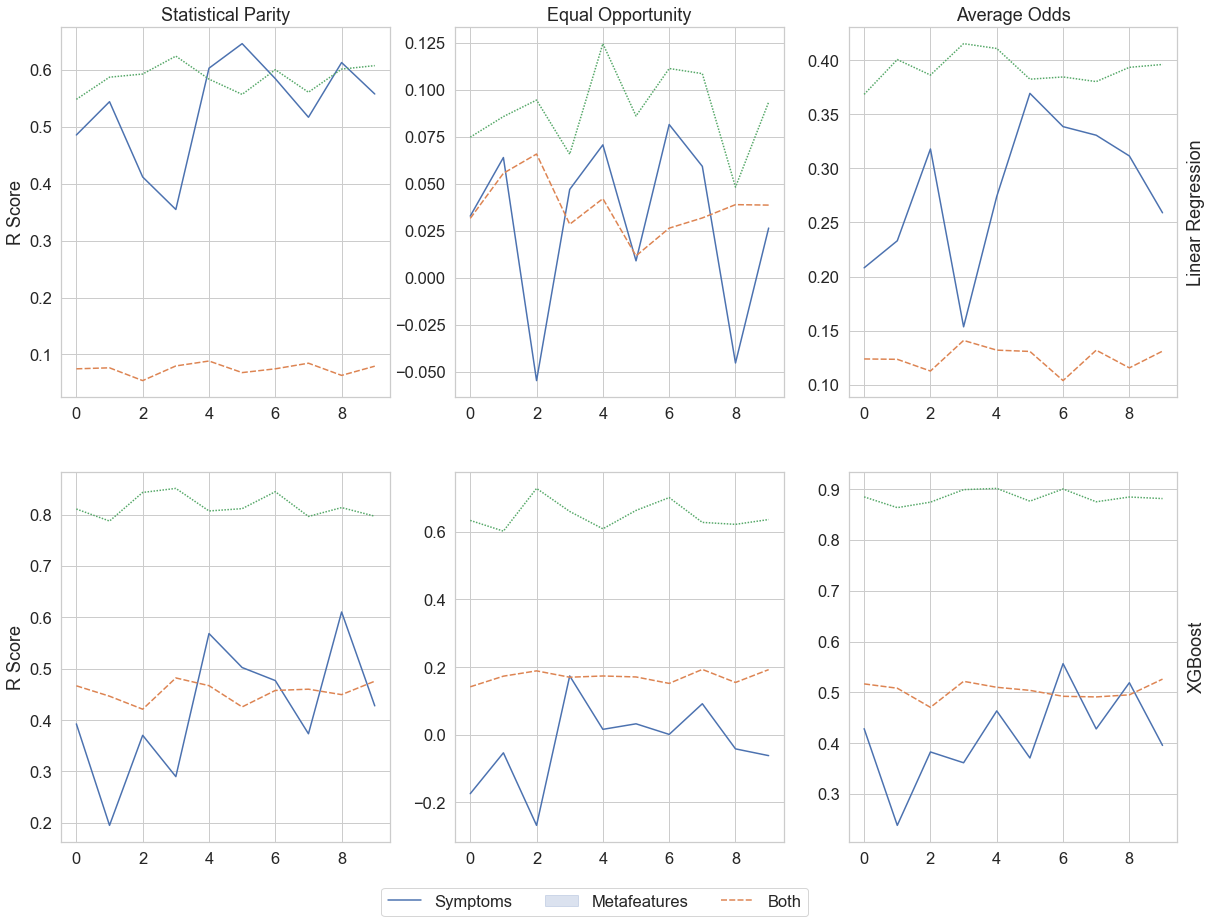

In [117]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))

sns.lineplot(
    data=[sp_linreg_symp, sp_linreg_meta, sp_linreg_joined], ax=ax[0, 0], legend=False
)
sns.lineplot(
    data=[ep_linreg_symp, ep_linreg_meta, ep_linreg_joined], ax=ax[0, 1], legend=False
)
sns.lineplot(
    data=[ao_linreg_symp, ao_linreg_meta, ao_linreg_joined], ax=ax[0, 2], legend=False
)
sns.lineplot(data=[sp_xgb_symp, sp_xgb_meta, sp_xgb_joined], ax=ax[1, 0], legend=False)
sns.lineplot(data=[eo_xgb_symp, ep_xgb_meta, ep_xgb_joined], ax=ax[1, 1], legend=False)
sns.lineplot(data=[ao_xgb_symp, ao_xgb_meta, ao_xgb_joined], ax=ax[1, 2], legend=False)

plt.legend(
    ["Symptoms", "Metafeatures", "Both"],
    loc="upper right",
    bbox_to_anchor=(-0.1, -0.1),
    ncol=3,
)
ax[0, 0].set_title("Statistical Parity")
ax[0, 1].set_title("Equal Opportunity")
ax[0, 2].set_title("Average Odds")
ax[0, 0].set_ylabel("R Score")
ax[1, 0].set_ylabel("R Score")
ax[0, 2].yaxis.set_label_position("right")
ax[0, 2].set_ylabel("Linear Regression", labelpad=10)
ax[1, 2].yaxis.set_label_position("right")
ax[1, 2].set_ylabel("XGBoost", labelpad=10)
plt.show()

C:\Users\giord\AppData\Local\Temp/ipykernel_3696/1029347155.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 0].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
C:\Users\giord\AppData\Local\Temp/ipykernel_3696/1029347155.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 1].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
C:\Users\giord\AppData\Local\Temp/ipykernel_3696/1029347155.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 2].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
C:\Users\giord\AppData\Local\Temp/ipykernel_3696/1029347155.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1, 0].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
C:\Users\giord\AppData\Local\Temp/ipykernel_3696/1029347155.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1, 1].set_xticklabels(["S

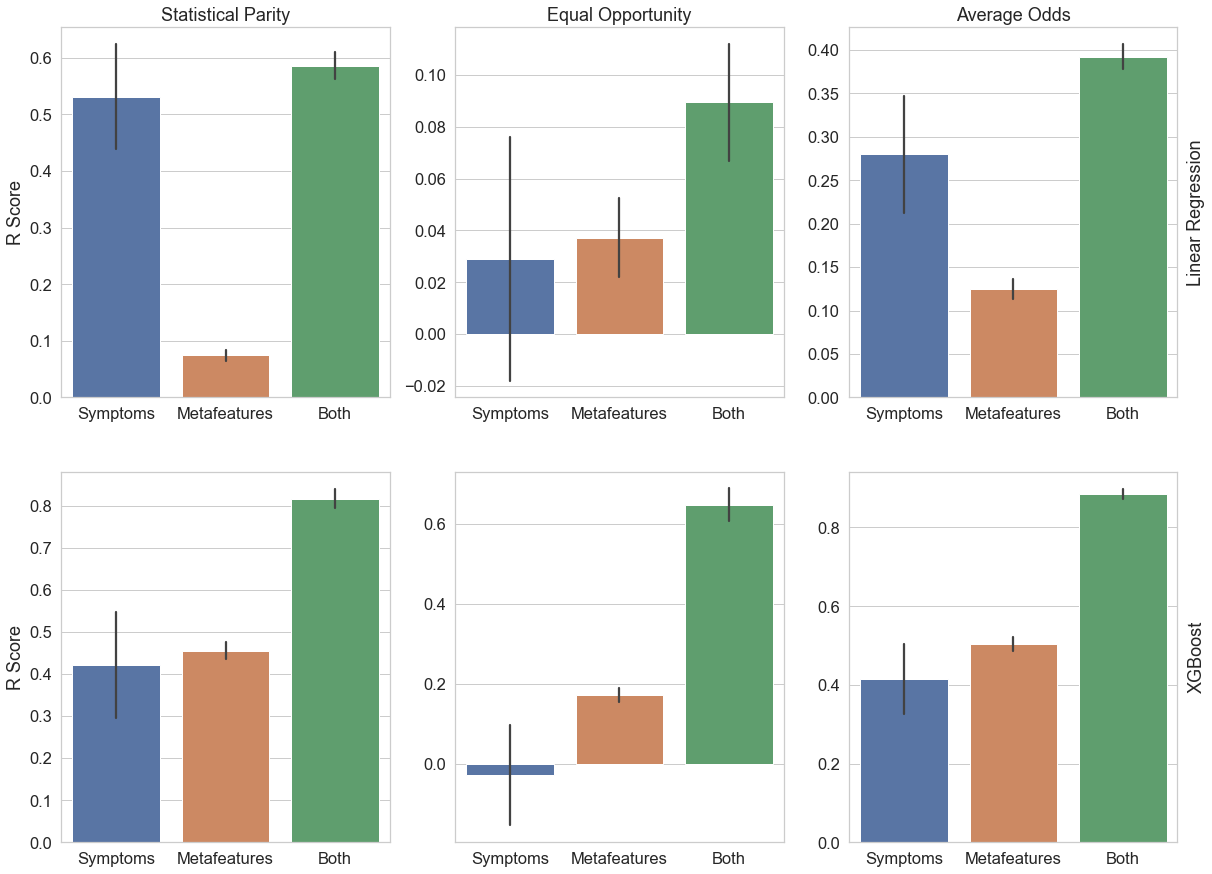

In [119]:
fig, ax = plt.subplots(2, 3, figsize=(20, 15))

sns.barplot(
    data=[sp_linreg_symp, sp_linreg_meta, sp_linreg_joined], errorbar="sd", ax=ax[0, 0]
)
sns.barplot(
    data=[ep_linreg_symp, ep_linreg_meta, ep_linreg_joined], errorbar="sd", ax=ax[0, 1]
)
sns.barplot(
    data=[ao_linreg_symp, ao_linreg_meta, ao_linreg_joined], errorbar="sd", ax=ax[0, 2]
)
sns.barplot(data=[sp_xgb_symp, sp_xgb_meta, sp_xgb_joined], errorbar="sd", ax=ax[1, 0])
sns.barplot(data=[eo_xgb_symp, ep_xgb_meta, ep_xgb_joined], errorbar="sd", ax=ax[1, 1])
sns.barplot(data=[ao_xgb_symp, ao_xgb_meta, ao_xgb_joined], errorbar="sd", ax=ax[1, 2])

ax[0, 0].set_title("Statistical Parity")
ax[0, 1].set_title("Equal Opportunity")
ax[0, 2].set_title("Average Odds")
ax[0, 0].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[0, 1].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[0, 2].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[1, 0].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[1, 1].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[1, 2].set_xticklabels(["Symptoms", "Metafeatures", "Both"])
ax[0, 0].set_ylabel("R Score")
ax[1, 0].set_ylabel("R Score")
ax[0, 2].yaxis.set_label_position("right")
ax[0, 2].set_ylabel("Linear Regression", labelpad=10)
ax[1, 2].yaxis.set_label_position("right")
ax[1, 2].set_ylabel("XGBoost", labelpad=10)
plt.show()

In [120]:
pd.DataFrame({
  "Stat Parity Symp": sp_linreg_symp,
  "Stat Parity Meta": sp_linreg_meta,
  "Stat Parity Both": sp_linreg_joined,
  "Equal Opportunity Symp": ep_linreg_symp,
  "Equal Opportunity Meta": ep_linreg_meta,
  "Equal Opportunity Both": ep_linreg_joined,
  "Average Odds Symp": ao_linreg_symp,
  "Average Odds Meta": ao_linreg_meta,
  "Average Odds Both": ao_linreg_joined
}).to_csv("model_scores/linreg.csv")